In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import scipy.stats as st
import random, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import *
import keras_tuner

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, f1_score
from sklearn import tree

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [54]:
PATH = r"C:\Users\PariahJack\Documents\GitHub\ancient_language_dataset\more_data\ALPUB_v2/images"
PATH_lap = r"C:\Users\PapaYaga\Documents\GitHub\ancient_language_dataset\ALPUB_v2\images"
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [56]:
image_size = (180, 180)
batch_size = 128

BASE_LETTERS, VAL_DS = tf.keras.utils.image_dataset_from_directory(
    directory=PATH_lap,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
    )

Found 205797 files belonging to 24 classes.
Using 174928 files for training.
Using 30869 files for validation.


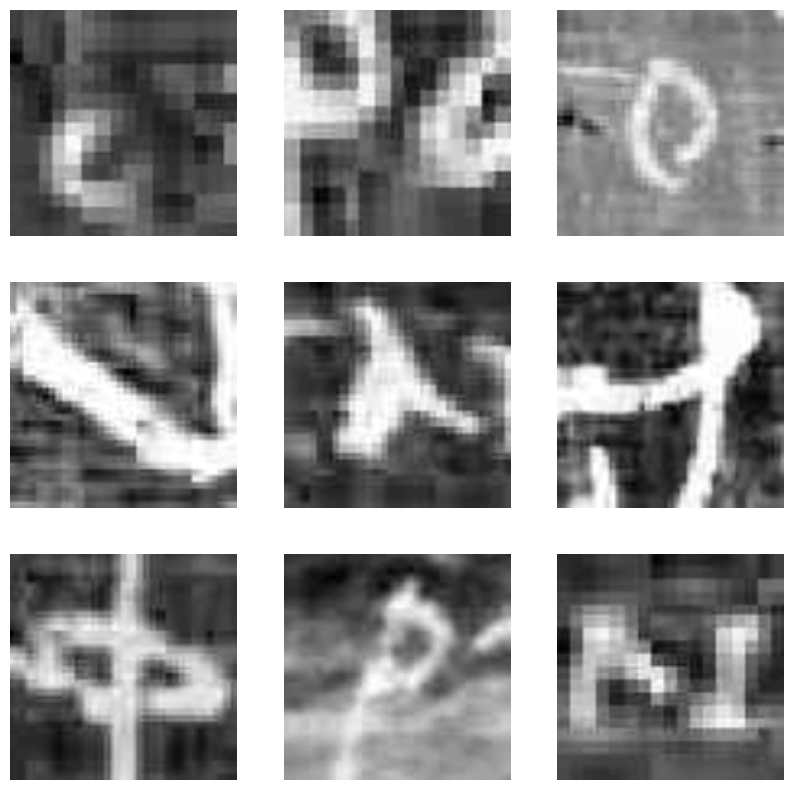

In [59]:
class_names = BASE_LETTERS.class_names

plt.figure(figsize=(10,10))
for images, labels in BASE_LETTERS.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        # plt.title(class_names[labels[i]])
        plt.axis("off")

In [60]:
BASE_LETTERS = BASE_LETTERS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [61]:
model = keras.Sequential(name="First_Test")
model.add(keras.Input(shape=(180, 180, 1)))  # 250x250 RGB images
model.add(Conv2D(32, 5, strides=2, activation="relu"))
model.add(Conv2D(32, 3, activation="relu"))
model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D(3))
model.add(Conv2D(32, 5))
model.add(GlobalAveragePooling2D())
model.add(Dense(24, activation="softmax"))
model.summary()


Model: "First_Test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 88, 88, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 86, 86, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 84, 84, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,752 (178.72 KB)

 Trainable params: 45,752 (178.72 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(
    optimizer="adam",  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [ ]:
run_model = model.fit(
    BASE_LETTERS,
    batch_size=batch_size,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=VAL_DS,
)


Epoch 1/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1200s 878ms/step - categorical_accuracy: 0.5082 - loss: 1.7096 - val_categorical_accuracy: 0.5001 - val_loss: 1.7599
Epoch 2/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1241s 908ms/step - categorical_accuracy: 0.5088 - loss: 1.7165 - val_categorical_accuracy: 0.5052 - val_loss: 1.7206
Epoch 3/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1217s 891ms/step - categorical_accuracy: 0.5102 - loss: 1.7072 - val_categorical_accuracy: 0.5020 - val_loss: 1.7340
Epoch 4/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1217s 890ms/step - categorical_accuracy: 0.5111 - loss: 1.7047 - val_categorical_accuracy: 0.5061 - val_loss: 1.7187
Epoch 5/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1216s 889ms/step - categorical_accuracy: 0.5135 - loss: 1.6927 - val_categorical_accuracy: 0.5047 - val_loss: 1.7202
Epoch 6/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1217s 890ms/step - categorical_accuracy: 0.5117 - loss: 1.6972 - val_categorical_accuracy: 0.5003 - val_loss: 1.7353
Epoch 7/20
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 1218